In [1]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
import dataset
import preprocessing
import classes
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import weighted_mode
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [4]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [5]:
X = dataset.data()
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X.shape
y.shape
dataset.labels_array()

array(['brötchen', 'kann', 'staubsauger', ..., 'other', 'other', 'other'],
      dtype='<U11')

In [7]:
X = dataset.data()[:, 12:76, :]
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train, X_test, y_train, y_test are numpy arrays
# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Assuming y_train contains integer labels
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # Assuming y_test contains integer labels

X_train_tensor = X_train_tensor.unsqueeze(dim=1)
X_test_tensor = X_test_tensor.unsqueeze(dim=1)

# Create training and test datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [9]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    drop_last=True,
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000020C7C1646D0>, <torch.utils.data.dataloader.DataLoader object at 0x0000020C7C1642B0>)
Length of train dataloader: 1132 batches of 32
Length of test dataloader: 283 batches of 32


In [10]:
class AudioClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifierCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        # Reshape the tensor to have a two-dimensional shape
        x = x.view(-1, 128 * 4 * 2)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [11]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate the loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Accumulate the accuracy

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient computation
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()  # Accumulate the loss
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))  # Accumulate the accuracy

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [12]:
# Initialize the model
model = AudioClassifierCNN(len(classes.CLASSES))

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.65682 | Train accuracy: 79.11%
Test loss: 0.26419 | Test accuracy: 90.58%

Epoch: 1
---------
Train loss: 0.23078 | Train accuracy: 91.99%
Test loss: 0.21070 | Test accuracy: 92.70%

Epoch: 2
---------
Train loss: 0.17401 | Train accuracy: 93.98%
Test loss: 0.17592 | Test accuracy: 93.89%

Train time on cuda: 23.996 seconds


In [14]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            
            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)
            print(pred_logit)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [15]:
import random
# random.seed(42)

test_samples = []
test_labels = []

# Sample from the test dataset until we have 9 samples with non-zero labels
while len(test_samples) < 20:
    sample, label = random.choice(list(test_dataset))
    if label != 0:
        test_samples.append(sample)
        test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes.class_to_label(int(test_labels[0]))})")

Test sample image shape: torch.Size([1, 64, 44])
Test sample label: 4 (ofen)


In [16]:

# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[ 3.6067, -3.4904, -2.2491, -1.9812,  6.2511, -3.5259, -3.4650, -3.0060,
         -3.5605, -5.7585, -5.9367]], device='cuda:0')
tensor([[  4.6130,  -3.7530,  -0.3713, -12.1709,   1.5378,  -5.8805,  -4.0090,
          -5.7384,   5.5566,  -4.4072,  -8.6304]], device='cuda:0')
tensor([[  5.0623,   0.3548,  -6.2104, -11.7869,  -2.8870,  -0.8515,   4.5567,
         -10.2974,  -8.8127,  -6.3412,   1.0767]], device='cuda:0')
tensor([[  9.1419, -18.8646, -10.8928,   1.2599,  -3.6175,  -4.9628,  -9.6432,
          13.9757, -11.4084,  -9.1713,  -7.2149]], device='cuda:0')
tensor([[ 3.6718,  1.7906, -6.8565, -3.5220, -3.2522,  5.9940,  4.6862, -8.4402,
         -9.8480, -8.3448, -0.8921]], device='cuda:0')
tensor([[ 2.4595, -4.4173,  5.0771, -4.9190, -0.5255, -3.1641, -2.6378, -5.9202,
         -4.5359, -1.6359, -2.1026]], device='cuda:0')
tensor([[ 4.5940, -5.9634, -3.1526, -2.1959,  4.3513, -6.1056, -5.6029, -2.6875,
         -3.3535, -1.9919, -3.1342]], device='cuda:0')
tensor([[  7.32

tensor([[6.6289e-02, 5.4854e-05, 1.8979e-04, 2.4810e-04, 9.3296e-01, 5.2940e-05,
         5.6263e-05, 8.9036e-05, 5.1142e-05, 5.6779e-06, 4.7513e-06],
        [2.7603e-01, 6.4219e-05, 1.8893e-03, 1.4184e-08, 1.2748e-02, 7.6507e-06,
         4.9715e-05, 8.8187e-06, 7.0916e-01, 3.3385e-05, 4.8914e-07]])

In [17]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 8, 0, 7, 5, 2, 0, 7, 4, 0, 5, 0, 5, 3, 6, 6, 6, 8, 9, 6])

In [18]:

# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([tensor(4),
  tensor(8),
  tensor(6),
  tensor(7),
  tensor(6),
  tensor(2),
  tensor(4),
  tensor(7),
  tensor(4),
  tensor(2),
  tensor(5),
  tensor(7),
  tensor(5),
  tensor(3),
  tensor(6),
  tensor(6),
  tensor(6),
  tensor(8),
  tensor(9),
  tensor(6)],
 tensor([4, 8, 0, 7, 5, 2, 0, 7, 4, 0, 5, 0, 5, 3, 6, 6, 6, 8, 9, 6]))

In [19]:

# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_true.append(y)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true).cpu()

Making predictions:   0%|          | 0/283 [00:00<?, ?it/s]

In [20]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


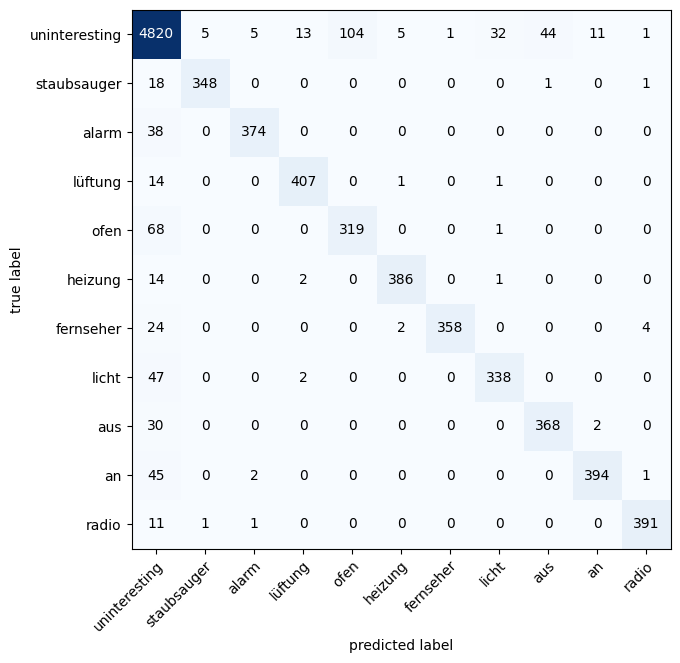

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=11, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=classes.CLASSES, # turn the row and column labels into class names
    figsize=(10, 7)
);